In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import rubin_sim.maf as maf
import rubin_sim.photUtils as photUtils
from rubin_sim.site_models import SeeingModel
import rubin_sim.utils as rsUtils
import syseng_throughputs as st

In [2]:
def calcM5(hardware, system, skysed, skymags, fwhmEff, photParams):
    sky_copy = photUtils.Sed()
    sky_copy.setSED(wavelen = skysed.wavelen, flambda = skysed.flambda)
    m5 = np.zeros(len(skymags))
    for i,f in enumerate(skymags):
        fluxNorm = sky_copy.calcFluxNorm(skymags[f], hardware[f])
        sky_copy.multiplyFluxNorm(fluxNorm)
        m5[i] = photUtils.calcM5(sky_copy, system[f], hardware[f],
                                 photParams, FWHMeff=fwhmEff[f])
    return m5

In [3]:
# Set up grid
X_range = np.arange(1, 2.5, .1)
texp_range = np.concatenate([np.arange(1, 10, 2), np.arange(10, 50, 5)])
sky_range = np.arange(16, 23, .5)
fwhm500_range = np.arange(0.5, 0.9, .03)

len(X_range), len(texp_range), len(sky_range), len(fwhm500_range), len(X_range)*len(texp_range)*len(sky_range)*len(fwhm500_range)

(15, 13, 14, 14, 38220)

In [4]:
sky_range

array([16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. ,
       21.5, 22. , 22.5])

In [5]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
# Set up PhotometricParameters object - which stores readnoise, etc
readnoise = 8.8 # e-/read
darkcurrent = 0.2 # e-/s
photParameters_15 = photUtils.PhotometricParameters(exptime=15, nexp=2, gain=1, 
                                                     readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
photParameters_30 = photUtils.PhotometricParameters(exptime=30, nexp=1, gain=1,
                                                   readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
# Make it easier to retrieve the appropriate version per-bandpass
photParams = {}
# Use all 2x15s tests here
photParams['u'] = photParameters_15
for f in ('g', 'r', 'i', 'z', 'y'):
    photParams[f] = photParameters_15

In [6]:
defaultdirs = st.setDefaultDirs()
defaultdirs

{'detector': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/joint_minimum',
 'lens1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens1',
 'lens2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens2',
 'lens3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens3',
 'filters': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/filters',
 'mirror1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror1',
 'mirror2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror2',
 'mirror3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror3',
 'atmosphere': '/Users/lynnej/lsst_repos/syseng_throughputs/siteProperties'}

In [7]:
# Read dark sky and X=1 atmosphere (default is to use X=1.2 atmosphere otherwise)
darksky = photUtils.Sed()
darksky.readSED_flambda(os.path.join(st.findRootDir(), 'siteProperties', 'darksky.dat'))
#atmosphere = st.readAtmosphere(defaultdirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')

hardware = {}
system = {}
atmosphere = {}
for i, x in enumerate(X_range):
    xn = f'{x:.1f}'.replace('.', '')
    filename = f'atmos_{xn}_aerosol.dat'
    atmosphere[x] = st.readAtmosphere('/Users/lynnej/rubin_sim_data/throughputs/atmos', atmosFile=filename)
    # READ WITHOUT ANY SYSTEM LOSSES
    hardware[x], system[x] = st.buildHardwareAndSystem(defaultdirs, 
                                                       atmosphereOverride=atmosphere[x], 
                                                       addLosses=False)

In [8]:
k = 1.0
ref = st.makeM5(hardware[k], system[k], darksky,
                exptime=15, nexp=2,
                readnoise=8.8, othernoise=0, darkcurrent=0.2,
                effarea=np.pi*(6.423/2*100)**2, X=1.0, fwhm500=0.72)
ref

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,1.042687,0.909088,22.963465,102.706669,27.293040,0.046546,0.073870,0.501469,0.038461,23.404984,0.498836,0.306623,23.954078,649.690159,23.9,23.4
g,0.978399,0.856244,22.261440,504.857550,28.606826,0.156097,0.190207,0.214582,0.038961,24.573826,0.148049,0.077377,24.841000,962.612823,25.0,24.6
r,0.921685,0.809625,21.196382,995.429681,28.367612,0.125230,0.140620,0.125843,0.039161,24.570205,0.080434,0.039720,24.369685,1192.043299,24.7,24.3
i,0.883574,0.778298,20.477231,1434.180778,28.074607,0.095611,0.104467,0.096182,0.039254,24.463433,0.057159,0.027330,23.949186,1340.569506,24.0,23.6
z,0.857015,0.756466,19.599734,2177.554843,27.678090,0.066359,0.070688,0.068613,0.039364,24.299498,0.038380,0.017653,23.379639,1572.178279,23.3,22.9
y,0.836727,0.739790,18.610555,2889.771889,26.895188,0.032266,0.037720,0.169574,0.039429,23.867749,0.029197,0.013024,22.479312,1751.747736,22.1,21.7


In [9]:
rsUtils.m5_scale(expTime=15, nexp=2, airmass=1.0, FWHMeff=ref['FWHMeff'], musky=ref['skyMag'],
                darkSkyMag=ref['skyMag'], Cm=ref['Cm'], dCm_infinity=ref['dCm_infinity'], kAtm=ref['kAtm'])

u    23.954078
g    24.841000
r    24.369685
i    23.949186
z    23.379639
y    22.479312
dtype: float64

In [10]:
calcM5(hardware[1.0], system[1.0], darksky, ref['skyMag'].to_dict(), ref['FWHMeff'].to_dict(), photParameters_15)

array([23.95407778, 24.84100033, 24.3696852 , 23.94918633, 23.37963899,
       22.47931194])

In [11]:
m5_calc = np.zeros([len(sky_range), len(X_range), len(fwhm500_range), len(texp_range), len(filterlist)], float)
m5_scale = np.zeros([len(sky_range), len(X_range), len(fwhm500_range), len(texp_range), len(filterlist)], float)

In [12]:
skymags_dict = {}
seeing_model = SeeingModel()

for i, sky in enumerate(sky_range):
    skymags_array = np.array([sky for f in filterlist])
    skymags_dict = dict(zip(filterlist, skymags_array))
    for j, x in enumerate(X_range):
        for k, fwhm500 in enumerate(fwhm500_range):
            fwhmEff_array = seeing_model(fwhm500, x)['fwhmEff']            
            fwhmEff_dict = dict(zip(filterlist, fwhmEff_array))
            for m, texp in enumerate(texp_range):
                photParam=photUtils.PhotometricParameters(exptime=texp, nexp=2, gain=1, 
                                                          readnoise=readnoise, othernoise=0, 
                                                          darkcurrent=darkcurrent)
                m5_calc[i,j,k,m] = calcM5(hardware[x], system[x], darksky, 
                                             skymags_dict, fwhmEff_dict, photParam)
                m5_scale[i,j,k,m] = rsUtils.m5_scale(expTime=texp, nexp=2, airmass=x,
                                                    FWHMeff=fwhmEff_array, musky=skymags_array,
                                                    darkSkyMag=ref['skyMag'], 
                                                     Cm=ref['Cm'], 
                                                     dCm_infinity=ref['dCm_infinity'], 
                                                     kAtm=ref['kAtm'])

In [50]:
# Probably should mask sky background values outside the useful range (because the differences can be large there)
skyranges= {}
skyranges['u'] = np.arange(20, 23, .1)
skyranges['g'] = np.arange(17, 22.5, .1)
skyranges['r'] = np.arange(17., 21.5, .1)
skyranges['i'] = np.arange(17, 20.5, .1)
skyranges['z'] = np.arange(16.5, 22, .1)
skyranges['y'] = np.arange(16, 19, .1)
skymask = np.ones([len(sky_range), len(X_range), len(fwhm500_range), len(texp_range), len(filterlist)], bool)
for i, sky in enumerate(sky_range):
    for j, x in enumerate(X_range):
        for k, fwhm500 in enumerate(fwhm500_range):
            for m, texp in enumerate(texp_range):
                for fi, f in enumerate(filterlist):
                    if (sky < skyranges[f].min()):
                        skymask[i,j,k,m,fi] = False
                    if (sky > skyranges[f].max() + .2):
                        skymask[i,j,k,m,fi] = False

In [51]:
diff = np.abs(m5_calc - m5_scale)
diff.shape

(14, 15, 14, 13, 6)

In [52]:
diff[~skymask] = -999

Text(0.5, 0, 'abs(m5 calc - m5 scaled)')

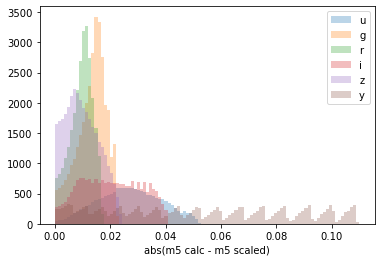

In [53]:
flist = np.arange(0, len(filterlist))
for fi, f in zip(flist, filterlist):
    n,b, p = plt.hist(diff[:,:,:,:,fi].flatten(), bins=100, range=[0, .11], alpha=0.3, label=f)
plt.legend()
plt.xlabel("abs(m5 calc - m5 scaled)")

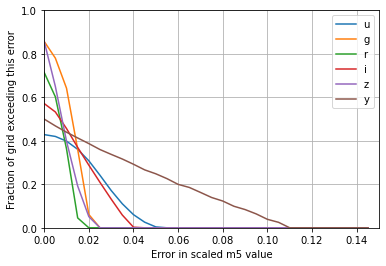

In [54]:
thresholds = np.arange(0.0, 0.15, .005)
for fi, f in zip(flist, filterlist):
    y = np.zeros(len(thresholds))
    for i, thresh in enumerate(thresholds):
        y[i] = len(np.where(diff[:,:,:,:,fi]> thresh)[0]) / len(diff[:,:,:,:,fi].flatten())
    plt.plot(thresholds, y, label=f)
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 0.15)
plt.xlabel('Error in scaled m5 value')
plt.ylabel('Fraction of grid exceeding this error')
plt.grid()

In [63]:
# What are the indexes for the closest to reference values in each of these ranges?
# sky -- need to figure out reasonable value for each bandpass
# fwhm500 -- 
skyindx = {}
for f in filterlist:
    skyindx[f] = np.where(np.abs(np.median(skyranges[f]) - sky_range) 
                      == np.abs(np.median(skyranges[f]) - sky_range).min())[0][0]
[sky_range[skyindx[f]] for f in filterlist], X_range[0], fwhm500_range[4], texp_range[9]

([21.5, 19.5, 19.0, 18.5, 19.0, 17.5], 1.0, 0.6200000000000001, 30)

Text(0.5, 0, 'exptime')

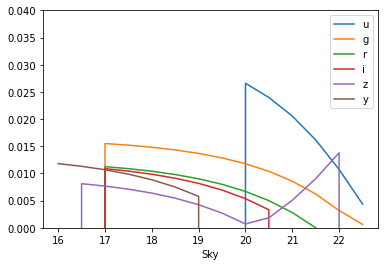

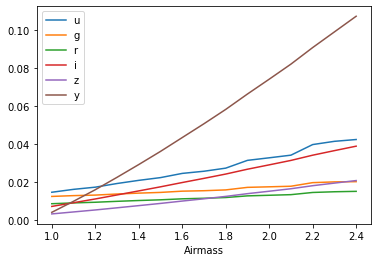

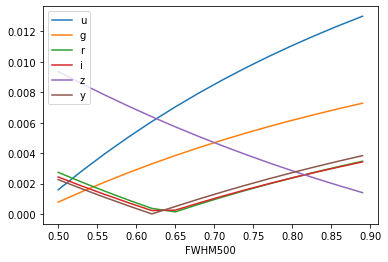

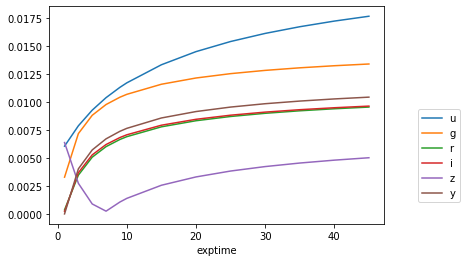

In [64]:
plt.figure()
for fi, f in zip(flist, filterlist):
    plt.plot(sky_range, diff[:, 1, 4, 9, fi], label=f)
plt.legend()
plt.ylim(0, .04)
plt.xlabel(f'Sky')
plt.figure()
for fi, f in zip(flist, filterlist):
    plt.plot(X_range, diff[skyindx[f], :, 4, 9, fi], label=f)
plt.legend()
plt.xlabel(f"Airmass")
plt.figure()
for fi, f in zip(flist, filterlist):
    plt.plot(fwhm500_range, diff[skyindx[f], 1, :, 0, fi], label=f)
plt.legend()
plt.xlabel(f"FWHM500")
plt.figure()
for fi, f in zip(flist, filterlist):
    plt.plot(texp_range, diff[skyindx[f], 1, 4, :, fi], linestyle='-', label=f)
plt.legend(loc=(1.1, 0.1))
plt.xlabel(f"exptime")

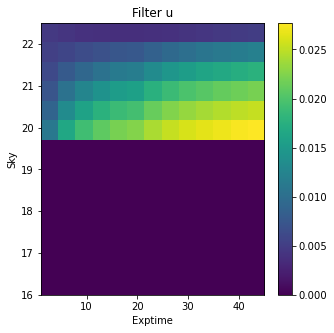

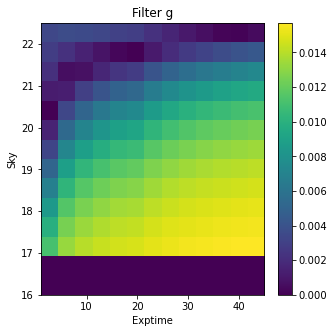

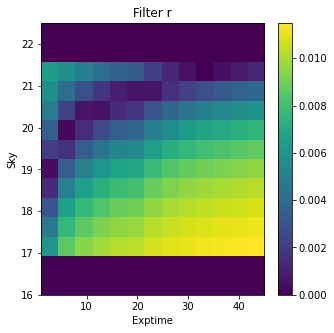

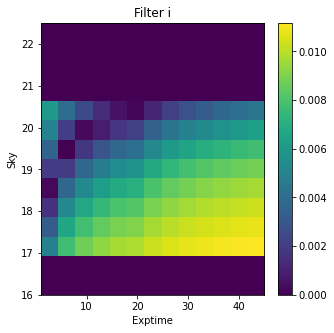

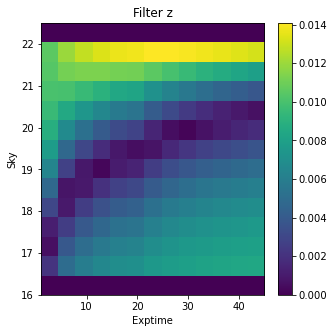

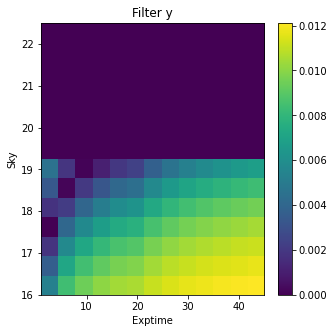

In [65]:
# sky vs. exptime 
diff = np.abs(m5_scale - m5_calc)
diff[~skymask] = 0

for fi,f in zip(flist, filterlist):
    plt.figure(figsize=(5,5))
    plt.imshow(diff[:, 1, 4, :, fi], 
               extent=[ texp_range.min(), texp_range.max(), sky_range.min(), sky_range.max()],
              aspect='auto', origin='lower')
    plt.colorbar()
    plt.ylabel('Sky')
    plt.xlabel("Exptime")
    plt.title(f'Filter {f}')

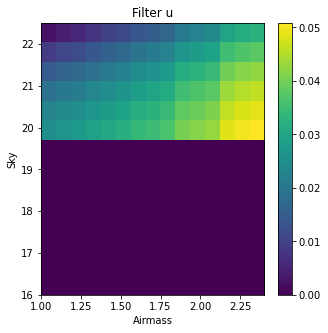

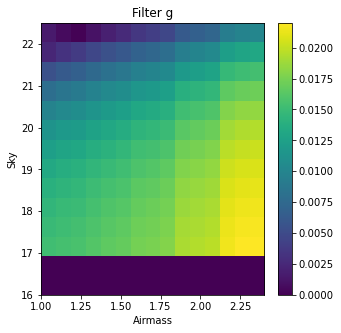

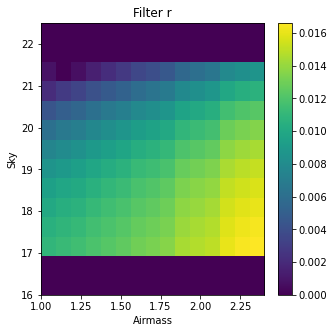

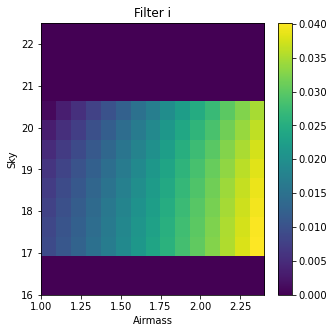

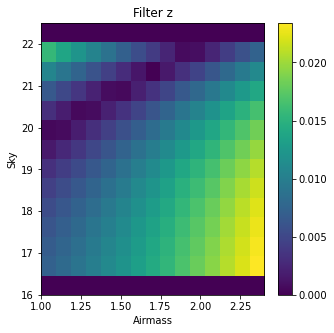

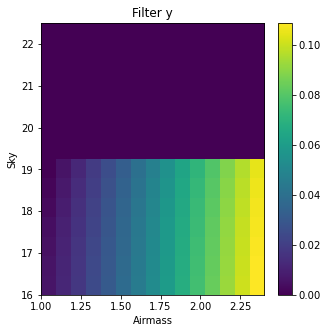

In [66]:
# sky vs. airmass 
diff = np.abs(m5_scale - m5_calc)
diff[~skymask] = 0

for fi,f in zip(flist, filterlist):
    plt.figure(figsize=(5,5))
    plt.imshow(diff[:, :, 4, 9, fi], 
               extent=[X_range.min(), X_range.max(), sky_range.min(), sky_range.max()],
              aspect='auto', origin='lower')
    plt.colorbar()
    plt.ylabel('Sky')
    plt.xlabel("Airmass")
    plt.title(f'Filter {f}')

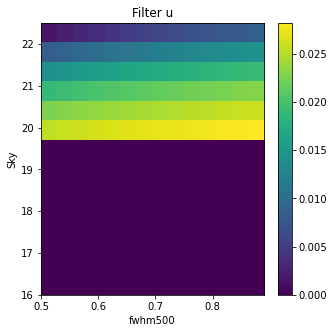

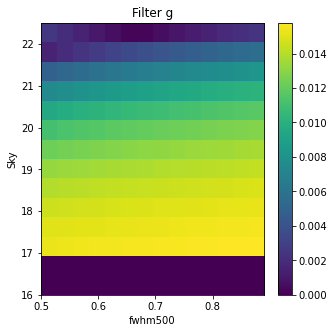

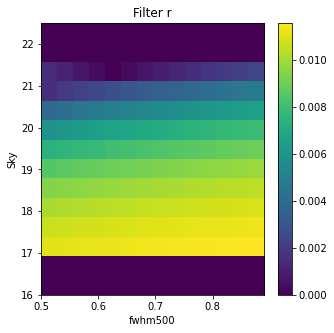

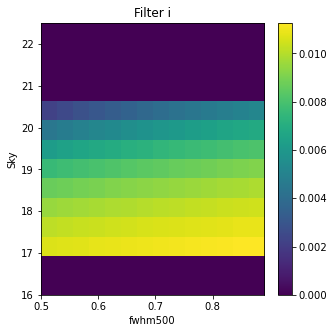

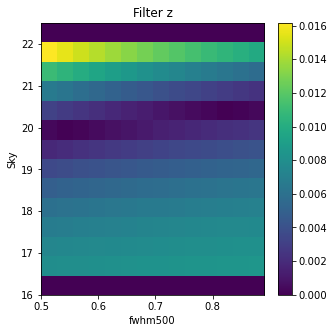

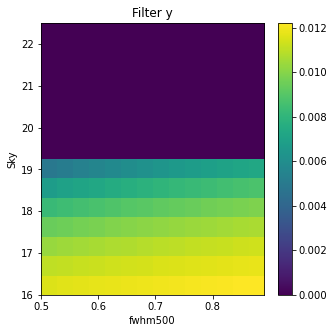

In [67]:
# sky vs. fwhm500 
diff = np.abs(m5_scale - m5_calc)
diff[~skymask] = 0

for fi,f in zip(flist, filterlist):
    plt.figure(figsize=(5,5))
    plt.imshow(diff[:, 1, :, 9, fi], 
               extent=[fwhm500_range.min(), fwhm500_range.max(), sky_range.min(), sky_range.max()],
              aspect='auto', origin='lower')
    plt.colorbar()
    plt.ylabel('Sky')
    plt.xlabel("fwhm500")
    plt.title(f'Filter {f}')

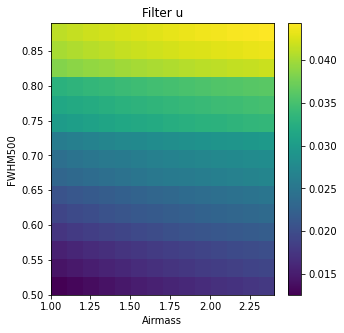

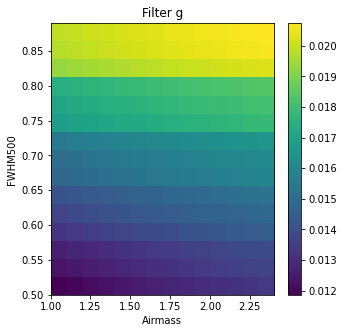

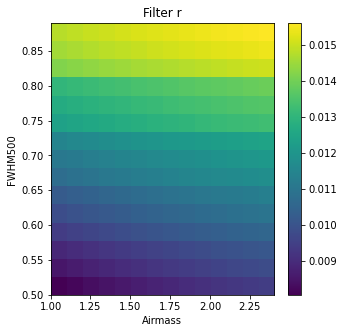

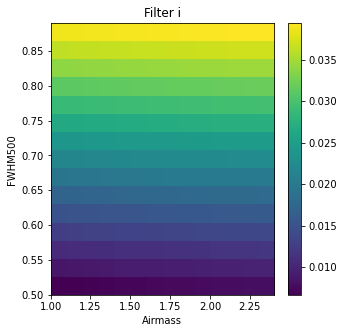

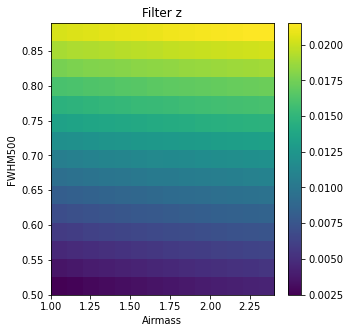

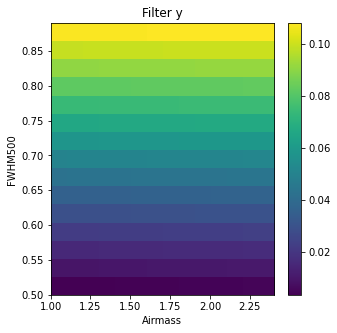

In [68]:
# fwhm vs. airmass 
diff = np.abs(m5_scale - m5_calc)
diff[~skymask] = 0

for fi,f in zip(flist, filterlist):
    plt.figure(figsize=(5,5))
    plt.imshow(diff[skyindx[f], :, :, 9, fi], 
               extent=[ X_range.min(), X_range.max(), fwhm500_range.min(), fwhm500_range.max()],
              aspect='auto', origin='lower')
    plt.colorbar()
    plt.ylabel('FWHM500')
    plt.xlabel("Airmass")
    plt.title(f'Filter {f}')

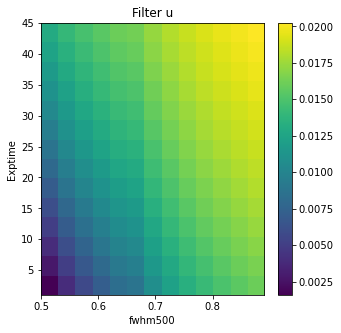

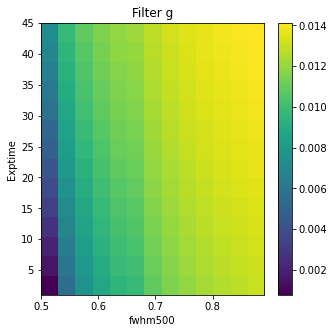

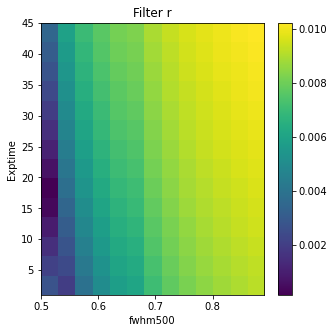

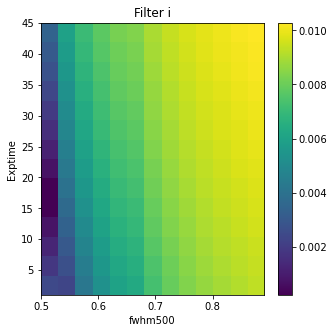

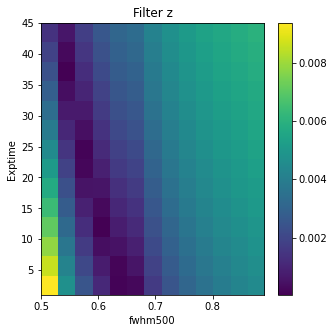

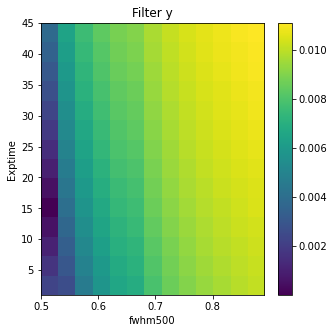

In [69]:
# fwhm500 vs. exptime 
diff = np.abs(m5_scale - m5_calc)
diff[~skymask] = 0

for fi,f in zip(flist, filterlist):
    plt.figure(figsize=(5,5))
    plt.imshow(diff[skyindx[f], 1, :, :, fi], 
               extent=[ fwhm500_range.min(), fwhm500_range.max(), texp_range.min(), texp_range.max()],
              aspect='auto', origin='lower')
    plt.colorbar()
    plt.ylabel('Exptime')
    plt.xlabel("fwhm500")
    plt.title(f'Filter {f}')

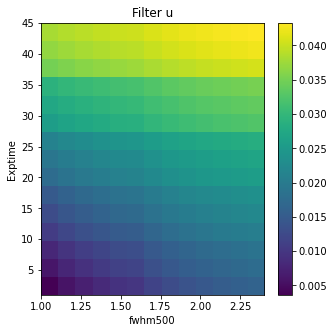

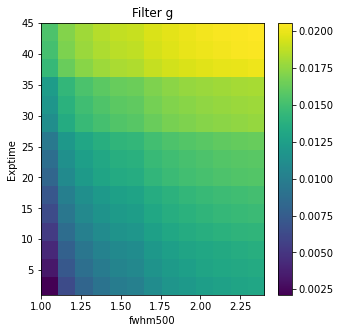

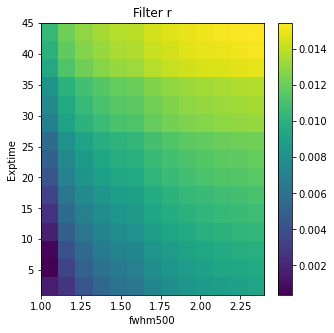

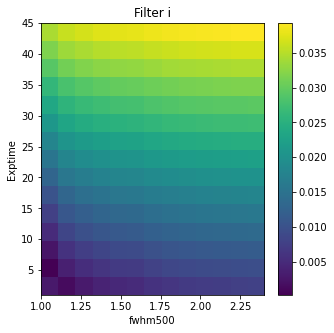

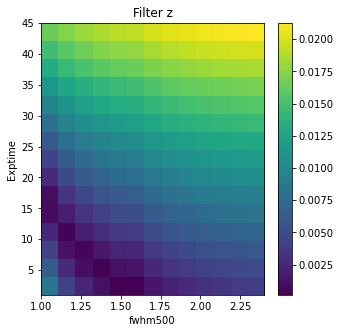

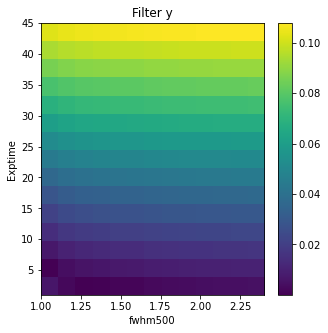

In [71]:
# airmass vs. exptime 
diff = np.abs(m5_scale - m5_calc)
diff[~skymask] = 0

for fi,f in zip(flist, filterlist):
    plt.figure(figsize=(5,5))
    plt.imshow(diff[skyindx[f], :, 4, :, fi], 
               extent=[ X_range.min(), X_range.max(), texp_range.min(), texp_range.max()],
              aspect='auto', origin='lower')
    plt.colorbar()
    plt.ylabel('Exptime')
    plt.xlabel("fwhm500")
    plt.title(f'Filter {f}')

In [72]:
mean = {}
median = {}
stdev = {}
#diff = np.abs(m5_scale - m5_calc)
diff = (m5_scale - m5_calc)
diff[~skymask] = 0
for fi, f in zip(flist, filterlist):
    mean[f] = np.mean(diff[:, :, :, :, fi])
    median[f] = np.median(diff[:, :, :, :, fi])
    stdev[f] = np.std(diff[:,:,:,:,fi])

In [73]:
pd.DataFrame([mean, median, stdev], index=['mean', 'median', 'stdev'])

,u,g,r,i,z,y
mean,-0.011579,-0.011222,-0.006647,-0.011607,-0.007065,-0.025546
median,0.000000,-0.013028,-0.007635,-0.007482,-0.007215,0.000000
stdev,0.015262,0.006760,0.005598,0.012915,0.008036,0.034449
